# RF predictor performance on train and test data

In [1]:
import os
import rioxarray as rioxr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import glob
import xarray as xr
import matplotlib.patches as mpatches
from sklearn.metrics import r2_score
import numpy.polynomial.polynomial as poly

import rasterio as rio

import pandas as pd 
import cftime as cft

import seaborn as sns

# Import user functions
import nbFunctions as myf 
import joblib 

In [2]:

from cycler import cycler

# plt.rcParams.update({'font.size': 16})
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
fs=14
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


''' --------
COLORS
-----------'''

### Timeseires 1997; 2015-2021
my_palette = sns.color_palette('crest',5) # can access i'th color by indexing
my_palette2 = ['salmon']+ my_palette
rgb_salmon = np.array([250,128,114])/255

my_palette2long = ['salmon']+ sns.color_palette('crest',7) 
rgb_salmon = tuple(np.array([250,128,114])/255)
my_palette2long = [rgb_salmon]+ sns.color_palette('crest',7) 
my_palette2rgb = [tuple(rgb_salmon)] + my_palette2long[1:] # only rgb values
print('Palette-long')
display(sns.color_palette(my_palette2rgb))

# print('magma palette_r : ', magma_palette_r.as_hex()) #[ '#A2CEFE',    '#FFAF78',    '#F1675D',    '#B54279',    '#721F82',    '#2B114F']
print('Palette-long: temporal_pallete 1997+crest : ', sns.color_palette(my_palette2long).as_hex()) 


Palette-long


[(0.9803921568627451, 0.5019607843137255, 0.4470588235294118),
 (0.50711872, 0.73665492, 0.56821764),
 (0.37890483, 0.66859548, 0.56566462),
 (0.28251558, 0.59517119, 0.56181204),
 (0.20094292, 0.52087429, 0.55342884),
 (0.12709242, 0.44601517, 0.54438795),
 (0.11646936, 0.36578429, 0.52726234),
 (0.15138673, 0.27982444, 0.49119848)]

Palette-long: temporal_pallete 1997+crest :  ['#fa8072', '#81bc91', '#61aa90', '#48988f', '#33858d', '#20728b', '#1e5d86', '#27477d']


In [3]:
homedir = '/Users/.../Documents/'


#### Functions

In [5]:

def plot_model_feature_info( my_model, feature_list , plot_cumul=False, ax=None, title='Variable Importances'):
    ## Feature importance # sorted to have highest first
    feature_importances = pd.DataFrame(my_model.feature_importances_, index =feature_list,  columns=['importance']).sort_values('importance', ascending=False)
    # print(feature_importances)
    
    # plot f.importance
    x_values = list(range(len(feature_list)))

    if ax is None:
        fig,ax=plt.subplots(1)

    # plt.figure()
    ax.bar(x_values, feature_importances['importance'], orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
    ax.set_xticks(x_values, feature_importances.index.values, rotation='vertical')
    ax.set_ylabel('Importance'); ax.set_xlabel('Variable'); ax.set_title(title);

    # plot c.f.importance
    if plot_cumul:
        cumulative_importances = np.cumsum(feature_importances) # Cumulative importances
        x_dummy=range(0,len(cumulative_importances))

        plt.figure()
        plt.plot(x_dummy, cumulative_importances, 'g-')
        # Draw line at 95% of importance retained -- arbitrary value!!! 
        plt.hlines(y = 0.95, xmin=0, xmax=len(feature_importances), color = 'r', linestyles = 'dashed')
        plt.xticks(x_dummy, feature_importances.index.values, rotation = 'vertical')
        plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances')
    
    return feature_importances, ax




# load RF

,importance
rema,0.194999
elon_1px,0.147630
v,0.145776
e_eff_1px,0.114748
emax_1px,0.102039
deltaV,0.084444
dEmax_1px,0.079899
etrans_1px,0.070437
eshear_1px,0.060029


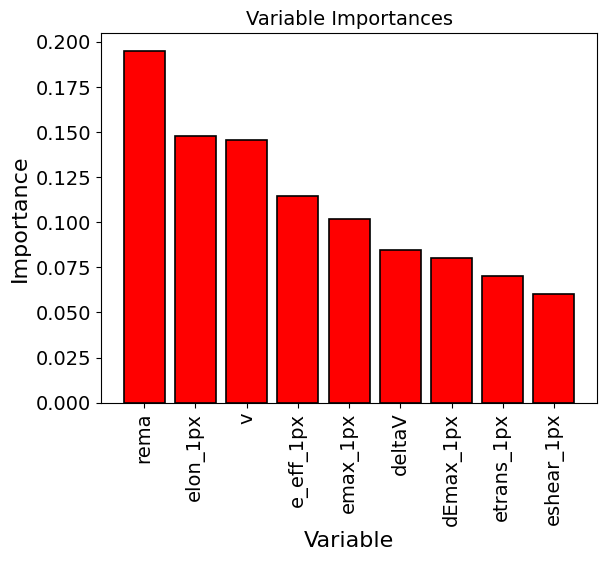

In [6]:


path2predictor = os.path.join('../files/')

''' GridSearch output '''

## Downsampled 20x20, dres=pct095
model_name = 'RF_gridSearch_bestEstimator.joblib'
configFile = 'RF_gridSearch.ini' # renamed file
iceshelves_testset = ['Shackleton', 'Amery', 'Rennick', 'Stange', 'Ross_East', 'Publications',
 'Pine_Island' ,'Bach', 'Dibble', 'Withrow', 'Abbot_3', 'Moubray' ,'Mendelssohn',
 'Whittle' ,'Wordie_(Prospect)', 'Deakin', 'Sandford', 'Wordie_(Harriott)'] # names based on MEASURES dataset
search_section = 'GRIDSEARCH'
space_section = 'GRIDSEARCHSPACE'


loaded_rf = joblib.load(os.path.join(path2predictor,model_name))

feature_list = list(loaded_rf.feature_names_in_)

loaded_rf.feature_importances_
# feature_list = 
feature_importances, ax = plot_model_feature_info( loaded_rf, feature_list , plot_cumul=False, ax=None, title='Variable Importances')
feature_importances

In [7]:
## Load config settings
import configparser
import json
config = configparser.ConfigParser(allow_no_value=True)
config.read(os.path.join(path2predictor,configFile))

## config for RandomForest randomSearchCV / gridSearchCV training
xvar_list = json.loads(config.get(search_section,"xvar_list")) # use json for reading lists
length_scales = config[search_section]['strain_length_scale_px'].split()
length_scales = [s.replace(',','').replace(' ','') for s in length_scales]  # remove any unintended remaining separatos
length_scales = [s + 'px' for s in length_scales]
dmg_type = config['DATA']['dmg_type']
dtresh_dict = {'dmg':'037', 'dmg095':'053' , 'dmg099':'063'}
dtresh=dtresh_dict[dmg_type]
ksize = int(config['DATA']['downsample_size'])

# Load Data

In [8]:
''' --------------
Get Shapefiles 
------------------ '''
# geojson
gridTiles_geojson_path = os.path.join(homedir,'Data/tiles/gridTiles_iceShelves_EPSG3031.geojson')
gridTiles = gpd.read_file(gridTiles_geojson_path)

# measures ice shelves
iceshelf_path_meas = os.path.join(homedir, 'QGis/Quantarctica/Quantarctica3/Glaciology/MEaSUREs Antarctic Boundaries/IceShelf/IceShelf_Antarctica_v02.shp')
iceshelf_poly_meas = gpd.read_file(iceshelf_path_meas)

## redefined: SECTORS for AIS
sector_path = os.path.join(homedir, 'QGis/data_NeRD/plot_insets_AIS_sectors.shp')
sector_poly = gpd.read_file(sector_path)
sector_ID_list = sector_poly['sector_ID'].to_list()
sector_ID_list = ['ASE','BSE','RS','EIS','WIS-a','WIS-b','WS-a','WS-b']

# annual ice shelves
path2iceshelves = os.path.join(homedir,'Data/Greene2022_AIS_coastlines/shapefiles/annual_iceshelf_polygons/revised_measures_greene/')
iceshelf_df_1997 = gpd.read_file(os.path.join(path2iceshelves, 'iceshelf_polygon_measures_greene_1997.75.shp' ) )
iceshelf_df_2015 = gpd.read_file(os.path.join(path2iceshelves, 'iceshelf_polygon_measures_greene_2015.2.shp' ) )
iceshelf_df_2016 = gpd.read_file(os.path.join(path2iceshelves, 'iceshelf_polygon_measures_greene_2016.2.shp' ) )
iceshelf_df_2017 = gpd.read_file(os.path.join(path2iceshelves, 'iceshelf_polygon_measures_greene_2017.2.shp' ) )
iceshelf_df_2018 = gpd.read_file(os.path.join(path2iceshelves, 'iceshelf_polygon_measures_greene_2018.2.shp' ) )
iceshelf_df_2019 = gpd.read_file(os.path.join(path2iceshelves, 'iceshelf_polygon_measures_greene_2019.2.shp' ) )
iceshelf_df_2020 = gpd.read_file(os.path.join(path2iceshelves, 'iceshelf_polygon_measures_greene_2020.2.shp' ) )
iceshelf_df_2021 = gpd.read_file(os.path.join(path2iceshelves, 'iceshelf_polygon_measures_greene_2021.2.shp' ) )

iceshelf_dict = {'1997':iceshelf_df_1997, '2015':iceshelf_df_2015,
                 '2016':iceshelf_df_2016, '2017':iceshelf_df_2017,
                 '2018':iceshelf_df_2018, '2019':iceshelf_df_2019,
                 '2020':iceshelf_df_2020, '2021':iceshelf_df_2021}

        

In [9]:
sector_ID_list

['ASE', 'BSE', 'RS', 'EIS', 'WIS-a', 'WIS-b', 'WS-a', 'WS-b']

# Load observed and predicted dmg

In [11]:

ais_dummy = myf.make_ais_grid(8e3)

#### Observed dmg

----
 Loading netCDF for region  ASE
..Downsampling data 20x20 pxs
----
 Loading netCDF for region  BSE
..Downsampling data 20x20 pxs
----
 Loading netCDF for region  AP
..Downsampling data 20x20 pxs
----
 Loading netCDF for region  DML
..Downsampling data 20x20 pxs


/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


----
 Loading netCDF for region  IOS
..Downsampling data 20x20 pxs
----
 Loading netCDF for region  WA
..Downsampling data 20x20 pxs
----
 Loading netCDF for region  RV
..Downsampling data 20x20 pxs
----
 Loading netCDF for region  FR
..Downsampling data 20x20 pxs
----
 Loading netCDF for region  tbd
..Downsampling data 20x20 pxs
----
 Loading netCDF for region  tbd2
..Downsampling data 20x20 pxs
---
 Merged to single dataset
.. resolution  (8000.0, 8000.0)m


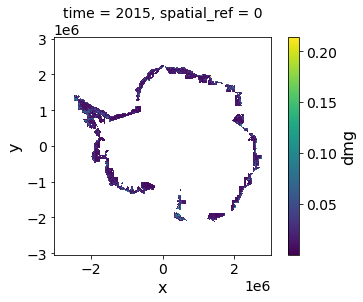

In [ ]:

path2data = os.path.join(homedir,'Data/NERD/data_predictor/data_sector/')
varname_obs = 'dmg095'


''' -------------------
Load all variables from individual netCDF files 
Expecting data directory to contain netCDFs per sector per training variable per year. 
filename convention: 'data_sector-{sector_ID}_{varname}_{year}.nc'
----------------------- '''

'''----------
## Load sector files
----------------'''
data_obs_ds_list=[]

ksize = 20
for sector_ID in sector_ID_list[:1]:#[:1]: 
    print('----\n Loading netCDF for region {}'.format(sector_ID))
    ''' Load damage variable '''
    # region_ds = load_nc_obs_data( os.path.join(path2data,'data_region/damage/'), region_ID, 
    #                                 varname=varname_obs, ksize=20 , parts=['part1', 'part2'])
    region_ds = myf.load_nc_sector_years( os.path.join(path2data,subdir), sector_ID, varName=varname_obs) # load all available years

    ''' ----------------
    Downsample observation data ( 400m to 8000m )
    --------------------'''
    
    if ksize:
        # with dask.config.set(**{'array.slicing.split_large_chunks': True}): # gives error?
        with dask.config.set(**{'array.slicing.split_large_chunks': False}): ## accept large chunks; ignore warning
            region_ds = myf.downsample_dataArray_withoutD0(region_ds, ksize=ksize, 
                                        boundary_method='pad',downsample_func='mean', skipna=False)
        
        dx = int(region_ds.rio.resolution()[0])
        dy = int(region_ds.rio.resolution()[1]) 
        new_res = ksize*400
        if np.abs(dx) != np.abs(dy):
            print( "x and y resolution are not the same; {} and {} -- resample to regular grid of {}m".format(
                        np.abs(int(region_ds.rio.resolution()[0])), 
                        np.abs(int(region_ds.rio.resolution()[1])), new_res ))
            grid_dummy = myf.make_regular_grid_for_ds(region_ds, grid_res=new_res)
            region_ds.rio.write_crs(3031, inplace=True)
            region_ds = myf.reproject_match_grid( grid_dummy, region_ds )     

        print('..Downsampling data {ksize}x{ksize} pxs'.format(ksize, ksize))

    # reproject to ISMIP grid (downsample)
    region_ds = myf.reprj_regions_to_ais_grid(ais_dummy,region_ds.transpose('time','y','x'))
    data_obs_ds_list.append(region_ds)



'''-----------------
## Combine to AIS dataset
---------------------'''
data_obs_ds = data_obs_ds_list[0] # initialise AIS wide dataset contianing 1 region of data
for ds in data_obs_ds_list[1:]:
    # combine_first() defaults to non-null values in the calling object, and fills holes with called object.
    # effecitvely patching all regions to the first
    data_obs_ds = data_obs_ds.combine_first(ds) 
    
print('---\n Merged to single dataset' )
print('.. resolution  {}m'.format(data_obs_ds.rio.resolution()))

fig,ax=plt.subplots(1)
data_obs_ds.isel(time=1)[varname_obs].plot.imshow(ax=ax)
ax.set_aspect('equal')

#### Predicted dmg

---
 Merged to single dataset
.. resolution  (8000.0, 8000.0)m


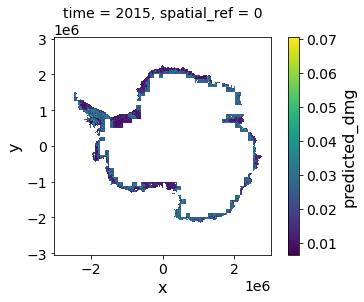

In [ ]:
# path2predicted = os.path.join(path2data, 'dmg_predicted/RF_oversampled/')
path2predicted = os.path.join(path2data, 'dmg_predicted/RF_unbalanced/')
varname_pred = 'dmg_predicted'

'''----------
## Load regional files
----------------'''
data_pred_ds_list=[]
for region_ID in region_ID_list:
    region_varfile = glob.glob(path2predicted + '*sector-'+region_ID+ '_*'+ varname_pred +'.nc')[0]
    region_ds = xr.open_dataset(region_varfile)
    
    # reproject to ISMIP grid
    region_ds = myf.reprj_regions_to_ais_grid(ais_dummy,region_ds.transpose('time','y','x'))

    data_pred_ds_list.append(region_ds)
region_ds
varname_pred = 'predicted_dmg'

'''-----------------
## Combine to AIS dataset
---------------------'''
data_pred_ds = data_pred_ds_list[0] # initialise AIS wide dataset contianing 1 region of data
for ds in data_pred_ds_list[1:]:
    # combine_first() defaults to non-null values in the calling object, and fills holes with called object.
    # effecitvely patching all regions to the first
    data_pred_ds = data_pred_ds.combine_first(ds) 
    
print('---\n Merged to single dataset' )
print('.. resolution  {}m'.format(data_pred_ds.rio.resolution()))

data_pred_ds

fig,ax=plt.subplots(1)
data_pred_ds.isel(time=0)[varname_pred].plot.imshow(ax=ax)
ax.set_aspect('equal')

In [ ]:
## 

'''-----------------
## Combine to single dataset
---------------------'''

data_dmg = xr.merge([data_obs_ds,data_pred_ds])
data_dmg
# varname_pred


<xarray.Dataset>
Dimensions:        (time: 8, y: 760, x: 760)
Coordinates:
  * time           (time) int64 1997 2015 2016 2017 2018 2019 2020 2021
  * x              (x) float64 -3.04e+06 -3.032e+06 ... 3.024e+06 3.032e+06
  * y              (y) float64 -3.04e+06 -3.032e+06 ... 3.024e+06 3.032e+06
    spatial_ref    int64 0
Data variables:
    dmg            (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    dmg095         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    dmg099         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    predicted_dmg  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan

# Plot predictions results -- observation and observation-predicted

## Which data to evaluate:
- Trained on data of 2015-2018 (selected ice shelves)
- Test data SPATIAL: data of 2015-2018, test-ice-shelves
- test data TEMPORAL: data of 2021, all AIS (2019-2020 are not independent)


# Regression per ice shelf - TRAIN / TEST

### clip to ice shelves

In [ ]:
## mask annual iceshelf

dmg_years_masked=[]
for ydx, year in enumerate([1997,2015,2016,2017,2018,2019,2020,2021]):
    print(year)
    ## CLIP data to iceshevles & select year 
    ishelf_gpd = iceshelf_dict[str(year)]
    dmg_year = data_dmg.sel(time=[year])[['dmg095','predicted_dmg']] # .where(~np.isnan(data_dmg.sel(time=year)), -999 )
    dmg_year  = dmg_year.rio.clip( 
                        ishelf_gpd.geometry, ishelf_gpd.crs, 
                        drop=True, invert=False)
    dmg_years_masked.append(dmg_year)
data_dmg = xr.concat ( dmg_years_masked, dim='time' )
data_dmg
# data_dmg.isel(time=-1).plot.imshow()

1997


/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape None at index 128 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape None at index 130 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape None at index 131 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/rasterio/features.py:318: ShapeSkipW

2015
2016


/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape None at index 159 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape None at index 159 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)


2017


/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape None at index 158 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape None at index 158 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)


2018


/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape None at index 160 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape None at index 160 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)


2019


/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape None at index 152 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape None at index 152 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)


2020


/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape None at index 157 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape None at index 157 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)


2021


/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape None at index 154 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/Users/tud500158/opt/anaconda3/envs/NERD2/lib/python3.9/site-packages/rasterio/features.py:318: ShapeSkipWarning: Invalid or empty shape None at index 154 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)


<xarray.Dataset>
Dimensions:        (y: 549, x: 647, time: 8)
Coordinates:
  * y              (y) float64 -2.136e+06 -2.128e+06 ... 2.24e+06 2.248e+06
  * x              (x) float64 -2.424e+06 -2.416e+06 ... 2.736e+06 2.744e+06
  * time           (time) int64 1997 2015 2016 2017 2018 2019 2020 2021
    spatial_ref    int64 0
Data variables:
    dmg095         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    predicted_dmg  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan

In [ ]:

def convert_to_gdf(region_ds, iceshelf_polygon_gpd):
    ''' ----------------
    Convert to dataFrame
    --------------------'''

    # ''' Stack to 1D '''
    region_ds_1d = region_ds.stack(samples=['x','y']) # (time, samples)

    print('.. Stacked {} pixels, convert to dataFrame'.format(len(region_ds_1d.samples)))

    data_pxs_df = region_ds_1d.to_dataframe() # nested dataframe
    data_pxs_df = data_pxs_df.rename(columns={"x": "x_coord", "y": "y_coord"}) # rename the column so that flattening the multi-index in the next step does not give an error (relevant for  pandas version > 1.4.3)

    # Flatten the nested multi-index to just column values -- automatically generates a 'year' value for every sample
    data_pxs_df = data_pxs_df.reset_index(level=['time','x','y']) # 18767504 rows; 

    # # Drop spatial ref (has not data acutally) 
    data_pxs_df = data_pxs_df.drop(['spatial_ref'],axis=1)


    ''' ----------------
    Drop NaN pixels:
    Pandas drops all rows that contain missing values. 
    - This means that if any variable has a NaN value, that px is dropped.
    --> should make sure to fill NaN values for variables before this step (e.g. dmg NaN is set to 0; filling of REMA gaps)
    - Since I have rows for px per year, this means that if I would have clipped the data to annual ice shelf polygons, the number of pixels per year can vary.  
    -------------------- '''

    data_pxs_df.dropna(axis='index',inplace=True) # Drop rows which contain missing values.

    ''' ----------------
    Add index of corresponding ice shelf to each point (to be used for spatial k-fold CV)
    1. Convert dataframe to geopandas dataframe
    2. Perform spatialjoin to iceshelf polygons
    Note: Do this step after dropping all NaN and dmg==0 points, as converting to geopandasDF is a bit slow on large dataFrames.
    --------------------'''

    print('.. converting to geopandas dataframe and identifying corresponding iceshelf per px')

    # 1. create geoDataFrame
    # gdf = gpd.GeoDataFrame( df_tmp, geometry=gpd.points_from_xy(df_tmp.x,df_tmp.y),crs='EPSG:3031')
    gdf_region = gpd.GeoDataFrame( data_pxs_df, geometry=gpd.points_from_xy( data_pxs_df.x, data_pxs_df.y ), crs='EPSG:3031')

    # 2. Identify to which ice shelf the points belong to, using geopandas spatial-join
    # 'index_right' is the row-idx of the iceshelf dataframe. Rename to 'iceshelf_index' because thats what i was looking for. 
    # NB: if a single ice shelf has multiple indices, this will result in multiple values. (e.g. 2x PiG will get #54 and #55 rather than 2x #54)
    # 'how=left' means that all values of the left dataset are kept and matched to the right one. All entries on the right-dataset that have no match, are discarded

    gdf_region = gdf_region.sjoin(iceshelf_polygon_gpd,how='left').drop(['Area','Regions'], axis=1)
    gdf_region = gdf_region.rename(columns={'index_right':'iceshelf_index'}) #.drop(['x','y','Area'],axis=1)
    # also add sector info (but only main sectors, not split parts)
    sectors_gpd = sector_poly.loc[sector_poly['sector_ID'].isin(['ASE','BSE','WIS','EIS','RS','WS'])]
    gdf_region = gdf_region.sjoin(sectors_gpd[['sector_ID','geometry']],how='left'
                            ).rename(columns={'index_right':'sector_index'}) 
                            # .drop(['index_right'], axis=1)

    ## 3. Drop all points that do not fall within an ice shelf geometry
    ## NB: this checks wrt MEASURES pxs, not to annual ice fronts.
    gdf_region = gdf_region.dropna(subset=['NAME']) # no iceshelf-name
    return gdf_region



## GET DATAFRAME ALL AIS
iceshelf_polygon_gpd = iceshelf_poly_meas.drop(['testField','TYPE'],axis=1).copy()
gdf_AIS = convert_to_gdf( data_dmg , iceshelf_polygon_gpd )

gdf_AIS.head()



.. Stacked 355203 pixels, convert to dataFrame
.. converting to geopandas dataframe and identifying corresponding iceshelf per px


,time,x,y,dmg095,predicted_dmg,geometry,iceshelf_index,NAME,sector_index,sector_ID
356187,2015,-2416000.0,1344000.0,0.028280,0.013356,POINT (-2416000.000 1344000.000),153.0,LarsenA,7,WS
356735,2015,-2408000.0,1336000.0,0.022207,0.018035,POINT (-2408000.000 1336000.000),153.0,LarsenA,7,WS
356736,2015,-2408000.0,1344000.0,0.011006,0.013277,POINT (-2408000.000 1344000.000),153.0,LarsenA,7,WS
356737,2015,-2408000.0,1352000.0,0.013217,0.015588,POINT (-2408000.000 1352000.000),153.0,LarsenA,7,WS
357285,2015,-2400000.0,1344000.0,0.009197,0.015673,POINT (-2400000.000 1344000.000),153.0,LarsenA,7,WS


In [ ]:

def plot_performance( y_in, y_pred , R2=999, alpha=0.2, s=5, ax=None, color='grey'):
    if ax is None:
        fig,ax=plt.subplots(1,figsize=(6,6))
    ax.scatter(y_in, y_pred, s=s, color=color, alpha=alpha )
    # ax.plot(ax.get_xlim(), ax.get_ylim(), color="red")

    # get axis limits and set them equal
    ax.set_aspect('equal')
    ax.plot(ax.get_xlim(), ax.get_xlim(),'k--'); ax.grid('on')
    ax.legend(handles=[ mpatches.Patch(color='none', label='R2={:.2f}'.format(R2)) ],
                             frameon=False,fontsize=16,loc='lower right')   
    ax.set_xlabel("Observed DMG ",fontsize=14)
    ax.set_ylabel("Predicted DMG",fontsize=14)
    ax.grid('on')

    return ax

### Split train and test

In [ ]:
iceshelves_testset = iceshelves_testset
iceshelves_testset.sort()
iceshelves_testset


['Abbot_3',
 'Amery',
 'Bach',
 'Deakin',
 'Dibble',
 'Mendelssohn',
 'Moubray',
 'Pine_Island',
 'Publications',
 'Rennick',
 'Ross_East',
 'Sandford',
 'Shackleton',
 'Stange',
 'Whittle',
 'Withrow',
 'Wordie_(Harriott)',
 'Wordie_(Prospect)']

## Plot weighted/unweighted regression
### Split  train/test

In [ ]:
gdf_AIS # has all years, all ice shelves


gdf_train = gdf_AIS.loc[gdf_AIS['time'].isin([2015,2016,2017,2018])]   # time selection
gdf_train = gdf_train.loc[~gdf_train['NAME'].isin(iceshelves_testset)] # icehself selection
gdf_test_spatial  = gdf_AIS.loc[    gdf_AIS['time'].isin([2015,2016,2017,2018]) ]
gdf_test_spatial = gdf_test_spatial.loc[  gdf_test_spatial['NAME'].isin(iceshelves_testset)]
gdf_test_temporal = gdf_AIS.loc[    gdf_AIS['time'] == 2021 ]

## do with/without spatial test-shelves iin temporoal dataset?
gdf_test_temporal = gdf_test_temporal.loc[   ~gdf_test_temporal['NAME'].isin(iceshelves_testset)]

''' -----------------
Count #px per ice shelf (all ice shelves)
-----------------'''
group_cols=['NAME']
metric_cols=['dmg095','predicted_dmg','sector_index']
df_count = gdf_AIS.groupby(group_cols).count()['x'] 

## Get 75th percentile of ice zhelves
minpx = np.percentile(df_count, 25 ) # 25th percent ice shelf size as threshold
minpx

7.0

In [ ]:

from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.linear_model import LinearRegression
import pprint # .pprint as pprint


def plot_jointplot_stats_w( df_plot, xvar, yvar, 
                    scatvar='px_count', scatter_size=30, sample_weight=None, 
                    ax=None, legend_on=True):
    x = df_plot[xvar]
    y = df_plot[yvar]

    ## scatter+regression plot
    if sample_weight is None:
        sample_weight = np.ones_like(x)
        # raise ValueError('Provide weights')
    try:
        sample_weight = sample_weight.values
    except:
        pass
    
    if len(df_plot['time'].unique()) == 1:
        if df_plot['time'].unique() == 2021:
            time_colors =[my_palette2long[-1]]
    else:
        time_colors = my_palette

    ax = sns.scatterplot(df_plot,x=xvar, y=yvar, 
                         hue='time',palette=time_colors,
                        #  s= scatter_size, 
                        alpha=0.7,
                        size=scatvar,sizes=(8,8e2), size_norm=(0,1e5),
                        # style='iceshelf_index',
                        ax=ax, 
                        legend=legend_on,
                        # legend='full', #legend_on,
                        )                    

    # Add the 1:1 line using matplotlib
    ax.set_aspect('equal')
    ax_range = [np.min( [ax.get_xlim() , ax.get_ylim() ] ),  np.max( [ax.get_xlim() , ax.get_ylim() ] )]
    # ax.plot(ax.get_ylim(), ax.get_ylim(), ls="--", c=".3", label='1:1')  # Plotting the 1:1 line
    ax.plot( ax_range, ax_range, ls="--", c=".3", label='1:1')  # Plotting the 1:1 line
    ax.set_aspect('equal')

    ## weighted values
    if sample_weight is not None:
        # The weighted model
        regr_w = LinearRegression().fit(x.values.reshape(-1, 1), y.values.reshape(-1, 1), sample_weight)
        regr_weighted = regr_w.predict(x.values.reshape(-1, 1))

        intercept  = regr_w.intercept_.flatten()[0]
        slope = regr_w.coef_.flatten()[0]

        # weithed / unweighted regression values
        # r2 = r2_score( x.values , y.values, sample_weight=sample_weight.values) # sklearn r2
        # r2 = my_r2(x.values , y.values, weights=sample_weight.values ) # same as sklearn
        r2 = regr_w.score(x.values.reshape(-1, 1), y.values.reshape(-1, 1), sample_weight) # coefficient of determination
        r = np.sqrt(r2)
        weight_descript ='Weighted'

        ## add to plot 
        ax.plot(x, regr_weighted, color='orangered', linewidth=1.1, 
                label='Weighted R2={:.2f}'.format(r2))


    if legend_on:
        ax.legend()
        sns.move_legend(ax,'upper left', bbox_to_anchor=(1.02,1),borderaxespad=0) # ,borderaxespad=0.1)

    # return graph, ax  #, (phantom, legend_info)
    ## regression values (weighted or unweighted)
    rmse = mean_squared_error(x, y, squared=False, sample_weight=sample_weight) # squred=True --> mse. squared=False-->rmse
    mse  = mean_squared_error(x, y, squared=True, sample_weight=sample_weight) 
    MAE_mean  = mean_absolute_error(x, y, sample_weight=sample_weight)# sample_weight) 
    mean_true = np.average(x, weights=sample_weight)
    mean_pred = np.average(y, weights=sample_weight)
    _, _, r_value, p_value, std_err = stats.linregress(x,y)
    if p_value > 0.01:
        raise ValueError(f'p_value is larger than 0.01; (p={p_value}) consider threshold p<0.05?')

    legend_info = ('r2={:.2f} \n'\
                    # 'slope={:.2f},\n'\
                    # 'intercept={:.2f}\n'\
                    'r ={:.2f}\n'\
                    'p <0.01'\
                    # 'RMSE={:.4f}\n'\
                    # 'MAE ={:.4f}'\
                    ).format(
                            r2,  
                            # slope,intercept, 
                            np.sqrt(r2),
                            # rmse, 
                            # MAE_mean,
                            )

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, legend_info, transform=ax.transAxes, fontsize=SMALL_SIZE, fontfamily='monospace',
            verticalalignment='top', bbox=props)

    ax.set_aspect('equal')
    return ax


/var/folders/f9/fhss4qg93y1b2w6dgpbxxwvw0000gn/T/ipykernel_81066/2476288208.py:30: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.scatterplot(df_plot,x=xvar, y=yvar,
/var/folders/f9/fhss4qg93y1b2w6dgpbxxwvw0000gn/T/ipykernel_81066/2476288208.py:30: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.scatterplot(df_plot,x=xvar, y=yvar,


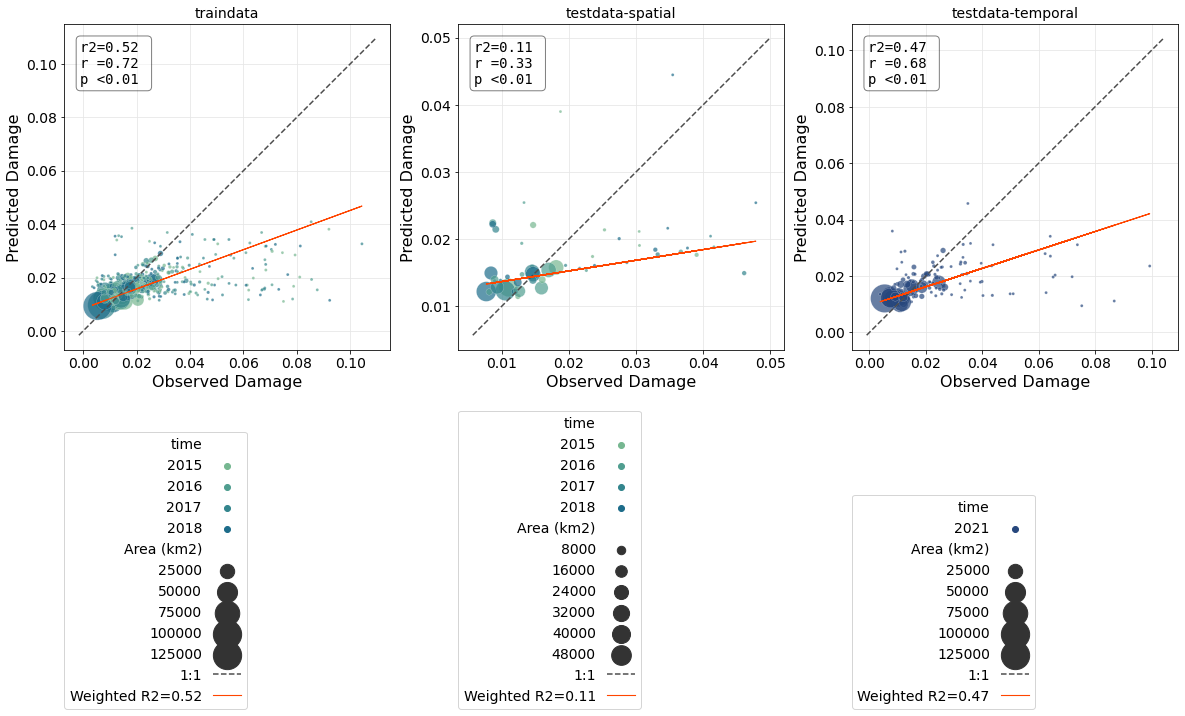

In [ ]:


''' -----------------
Count #px per ice shelf (all ice shelves)
-----------------'''
group_cols=['NAME']
metric_cols=['dmg095','predicted_dmg','sector_index']
df_count = gdf_AIS.groupby(group_cols).count()['x'] 

## Get percentile of ice zhelves sizes
minpx = np.percentile(df_count, 25 ) # == 9 px  ##  25th percent ice shelf size as threshold
# minpx = 5
minpx


''' -----------------
Specify dataset (train/test)
-----------------'''
fig,axs=plt.subplots(1,3,figsize=(20,6), sharex=False)
k=0
for df_iceshelf_spatialAvg,title_str in zip(
                    [gdf_train.copy(), gdf_test_spatial.copy(), gdf_test_temporal.copy()],
                    ['traindata','testdata-spatial','testdata-temporal']):


    set_descript = title_str

    ''' -----------------
    spatial avgs
    -----------------'''
    group_cols=['NAME','time']
    metric_cols=['dmg095','predicted_dmg','sector_index']

    df_avgs = df_iceshelf_spatialAvg.groupby(group_cols)[metric_cols].mean() ## Spatial average
    df_count = df_iceshelf_spatialAvg.groupby(group_cols).count()['x'] # count is the same for all columns; just select one
    df_avgs['px_count'] = df_count
    df_avgs['Area (km2)'] = df_count*8*8 # km2

    # add sector-info back to grouped df
    df_iceshelf_spatialAvg.drop(metric_cols, axis=1, inplace=True) # drop calculated values from df; to be replaced
    df_iceshelf_spatialAvg.drop_duplicates(subset=group_cols, keep='last', inplace=True) # dedupe to leave only one row with each combination of group_cols in df
    df_iceshelf_spatialAvg = df_iceshelf_spatialAvg.merge(right=df_avgs, right_index=True, left_on=group_cols, how='right') # add the mean columns from aggs into df

    ''' -----------------
    Select what to plot
    -----------------'''

    ## All px/iceshelves
    df_plot = df_iceshelf_spatialAvg.copy()

    ## PLOT ONLY IF iceshelf > minpx
    if not 'spatial' in title_str:
        print('SELECTING ICE SHELVES > {} px '.format(minpx) )
        df_plot = df_plot.loc[df_plot['px_count']>minpx]
        title_str += ' Npx>{}'.format(minpx)
    else:
        minpx=0

    title_str += ' ({} "ishelves")'.format(len(df_plot))

    xvar=dmg_type
    yvar=varname_pred
    # scatter_size = [np.max([5,item]) for item in  df_plot['px_count']/10]
    # scatter_size = [np.max([5,item]) for item in  df_plot['px_count']/2]
    scatter_size=None


    ''' -----------------
    PLOT Weighted regression
    -----------------'''

    x = df_plot[xvar].values
    y = df_plot[yvar].values
    sample_weight = df_plot['px_count']
    sample_weight = df_plot['Area (km2)']
    # sample_weight = None

    ### FUNCTION PLOT

    # fig,ax=plt.subplots(1,figsize=(8,6))
    # fig,axs=plt.subplots(1,3,figsize=(8,6))
    ax=axs[k]
    ax  = plot_jointplot_stats_w( df_plot, xvar, yvar, 
                                    scatvar='Area (km2)',  scatter_size=scatter_size, 
                                    sample_weight=sample_weight, legend_on = True,
                                    ax=ax )
    # ax.set_xlabel(r'Observed $\sum_{i_{shelf}} {Damage}$', fontname=label_font)
    ax.set_xlabel('Observed Damage')#, fontname='Arial Unicode')#label_font)
    ax.set_ylabel('Predicted Damage')
    ax.set_title(set_descript)

    ax.set_axisbelow(True)
    ax.grid(color=[0.9,0.9,0.9])

    # if legend_on:
    ax.legend()
    sns.move_legend(ax,'lower left', bbox_to_anchor=(0,-1.1),borderaxespad=0, markerfirst=False) # ,borderaxespad=0.1)


    k+=1



# Structural similarity index

In [ ]:
def interpolate_grid( dmg_iceshelf , refine_res = 2):
    # define grid with higher res

    # refine_res = 2 # double resolution

    if dmg_iceshelf.dims['x'] > 1:
        x0 = dmg_iceshelf.x[0].values; x1 = dmg_iceshelf.x[-1].values
        dx = dmg_iceshelf.rio.resolution()[0]
        x_int = np.arange(x0,x1+dx, step=int(dx/refine_res)) # double resolution
    else:
        x_int = None
    if dmg_iceshelf.dims['y'] > 1:    
        y0 = dmg_iceshelf.y[0].values; y1 = dmg_iceshelf.y[-1].values
        dy = dmg_iceshelf.rio.resolution()[1]
        y_int = np.arange(y0,y1+dy, step=int(dy/refine_res))
    else:
        y_int = None
    if x_int is not None and y_int is not None:
        # 2D interpolate (linear)
        dmg_interp = dmg_iceshelf.interp(x=x_int, y=y_int, method="linear", 
                            assume_sorted=True,
                            kwargs={'fill_value':'extrapolate'})
    elif x_int is not None:
        # 1D interpolation (x)
        dmg_interp = dmg_iceshelf.interp(x=x_int, method="linear", 
                            assume_sorted=True,
                            kwargs={'fill_value':'extrapolate'})
    elif y_int is not None:
        # 1D interpolation (x)
        dmg_interp = dmg_iceshelf.interp(y=y_int, method="linear", 
                            assume_sorted=True,
                            kwargs={'fill_value':'extrapolate'})

    return dmg_interp

In [ ]:
## Calculate Structural SImilarity index
from skimage.metrics import structural_similarity as ssim
def round_up_to_odd(f):
    return np.ceil(f) // 2 * 2 + 1

# year_obs = 2021
iceshelf_polygon_gpd = iceshelf_poly_meas.sjoin(sector_poly,how='left').drop(['index_right','id','testField'],axis=1)


iceshelves_region = iceshelf_polygon_gpd # .loc[iceshelf_polygon_gpd['region_ID']==region_ID_list[index]] 

iceshelf_names_region = iceshelves_region['NAME'].unique()
ssim_df = pd.DataFrame()

iceshelves_too_small = []
for iceshelf_name in iceshelves_region['NAME'].unique():
    iceshelf = iceshelves_region.loc[iceshelves_region['NAME']==iceshelf_name]
    # print(iceshelf_name)
    
    try:
        dmg_iceshelf = data_dmg[[dmg_type, varname_pred]].rio.clip(iceshelf.geometry)
    except rioxr.exceptions.NoDataInBounds:
        pass
    
    '''
    # Interpolate grid so there are more pixels to base SSIM on
    '''
    # define grid with higher res
    if dmg_iceshelf.dims['x'] == 1 and dmg_iceshelf.dims['y'] == 1:
        # print('.. {} 1 px ice shelf, cannot interp, continue'.format(iceshelf_name, 
        #                 dmg_iceshelf[dmg_type].shape))
        iceshelves_too_small.append( ( iceshelf_name, dmg_iceshelf[dmg_type].shape) )
        continue
    
    refine_res = 2 # double resolution
    refine_res = 3 # triple resolution
    dmg_interp = interpolate_grid( dmg_iceshelf , refine_res = refine_res)
    dmg_iceshelf = dmg_interp.where(dmg_interp>0,other=0) # set values below 0 back to 0


    '''
    ## SSIM setting depending on size of ice shelf
    '''
    win_size = 7
    win_size = np.min( list(dmg_iceshelf[dmg_type].shape)+[win_size])
    if win_size < 5:
        # print('.. {} too small area, size={}, continue'.format(iceshelf_name, 
        #                 dmg_iceshelf[dmg_type].shape))
        iceshelves_too_small.append( (iceshelf_name, dmg_iceshelf[dmg_type].shape))
        continue
    if (win_size % 2) == 0: # if even, convert to odd number
        win_size -= 1


    ''' ----------------
    Get Observational and observation-predicited dmg
    --------------------'''
    
        
    # fig,axs=plt.subplots(1,3, figsize=(12,6))
    ssim_iceshelf_years = []
    ssim_dict=dict()
    # for i,year in enumerate([2019, 2020, 2021]):
    for i,year in enumerate(range(2015,2022)):
        dmg_year_ds = dmg_iceshelf.drop('spatial_ref').sel(time=year).drop('time')
        # y_predict_da = region_predicted.sel(time=year).drop('time')
        dmg_year_ds = dmg_year_ds.fillna(0)

        y_true_da = dmg_year_ds[dmg_type]
        y_predict_da = dmg_year_ds[varname_pred]

        ''' ----------------
        Differences predicited-observed ( percentage diff? or absolute)
        --------------------'''

        # diff_pred_obs_MAPE  = (y_pred_rf_da_obs - region_year_ds[dmg_type] ) / region_year_ds[dmg_type] * 100
        diff_pred_obs_MAE   = (y_predict_da - y_true_da )

        ''' ----------------
        Structural Similarity Index
        --------------------'''
        
        ssim_year, ssim_img =  ssim(y_true_da, y_predict_da, data_range=0.2, full=True,win_size=win_size)
        ssim_iceshelf_years.append(ssim_year)
        # ssim_dict['ssim_'+str(year)] = ssim_year
        ssim_dict[str(year)] = ssim_year

    ''' Store ssim values'''
    # ssim_iceshelves.append(ssim_iceshelf_years)
    ssim_df = pd.concat([ssim_df, pd.DataFrame(ssim_dict,index=[iceshelf_name])])
    
## Print SSIM for each iceshelf

ssim_df = pd.melt(ssim_df.rename_axis('NAME').reset_index(), id_vars='NAME', var_name='year', value_name='SSIM')


#### Plot SSIM perfomrance

/var/folders/f9/fhss4qg93y1b2w6dgpbxxwvw0000gn/T/ipykernel_81066/3352703877.py:40: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  ax = sns.histplot(data=ssim_iceshelf, x='SSIM', multiple='stack', ax=ax,
/var/folders/f9/fhss4qg93y1b2w6dgpbxxwvw0000gn/T/ipykernel_81066/3352703877.py:61: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  ax = sns.histplot(data=ssim_iceshelf, x='SSIM', multiple='stack',ax=ax,


Text(0.5, 1.0, 'testdata-temp')

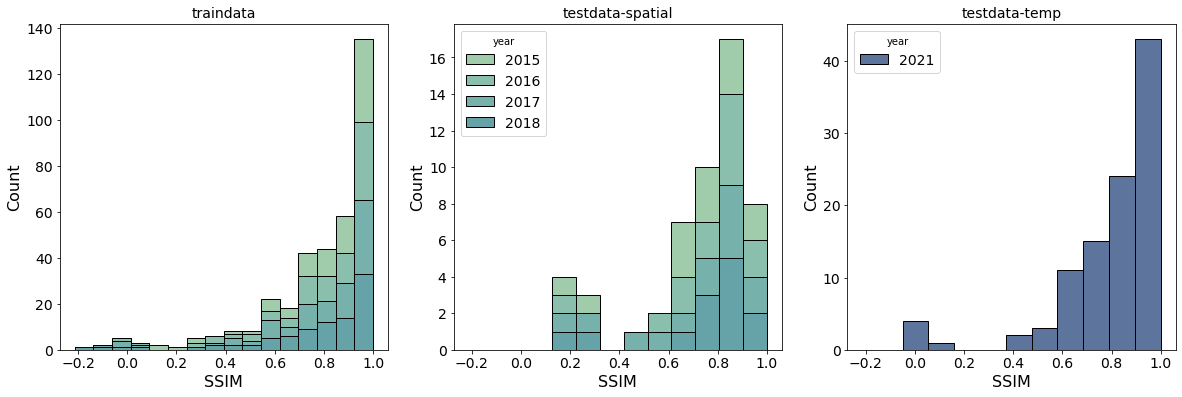

In [ ]:
## Print SSIM for each iceshelf

ssim_train = ssim_df.loc[ssim_df['year'].isin(['2015','2016','2017','2018'])]  # time selection
ssim_train = ssim_train.loc[~ssim_train['NAME'].isin(iceshelves_testset)] # icehself selection

ssim_test_spatial  = ssim_df.loc[ssim_df['year'].isin(['2015','2016','2017','2018'])]  # time selection
ssim_test_spatial = ssim_test_spatial.loc[  ssim_test_spatial['NAME'].isin(iceshelves_testset)]
ssim_test_temporal = ssim_df.loc[ssim_df['year'] == '2021']


ssim_values_df = pd.DataFrame()

'''
## PLOT TRAIN
'''

# ## PLOT ONLY TRAINDATA
ssim_iceshelf = ssim_train # .values # ssim_df.mean(axis=1)
title_str = 'traindata'
year_labels = ['2015','2016','2017','2018',]

ssim_values_dict = {'mean_SSIM':ssim_iceshelf['SSIM'].mean(),
             'std_SSIM':ssim_iceshelf['SSIM'].std() }
ssim_values_df = pd.concat([ssim_values_df, pd.DataFrame(ssim_values_dict,index=[title_str])])

# Plot values
fig,axs=plt.subplots(1,3,figsize=(20,6), sharex=True)


ax=axs[0]
ax = sns.histplot(data=ssim_iceshelf, x='SSIM', multiple='stack', ax=ax,
                hue='year' ,palette = my_palette2long[1:],legend=True,
                )
ax.set_title(title_str)
# ax.legend(year_labels)


'''
## TEST SPATIAL
'''

# ## PLOT ONLY TESTDATA-spatial
ssim_iceshelf = ssim_test_spatial # ssim_df.mean(axis=1)
title_str = 'testdata-spatial'

ssim_values_dict = {'mean_SSIM':ssim_iceshelf['SSIM'].mean(),
             'std_SSIM':ssim_iceshelf['SSIM'].std() }
ssim_values_df = pd.concat([ssim_values_df, pd.DataFrame(ssim_values_dict,index=[title_str])])

## Plot values
ax=axs[1]
ax = sns.histplot(data=ssim_iceshelf, x='SSIM', multiple='stack',ax=ax,
                hue='year' ,palette = my_palette2long[1:], legend=True,
                )
ax.set_title(title_str)
# ax.legend(year_labels)


'''
## TEST TEMPORAL
'''

## PLOT ONLY TESTDATA-temporal
ssim_iceshelf = ssim_test_temporal # ssim_df.mean(axis=1)
title_str = 'testdata-temporal'

ssim_values_dict = {'mean_SSIM':ssim_iceshelf['SSIM'].mean(),
             'std_SSIM':ssim_iceshelf['SSIM'].std() }
ssim_values_df = pd.concat([ssim_values_df, pd.DataFrame(ssim_values_dict,index=[title_str])])

## Plot values
ax=axs[2]
ax = sns.histplot(data=ssim_iceshelf, x='SSIM', multiple='stack',ax=ax,
                hue='year' ,palette = my_palette2long[-1:],legend=True,
                )
ax.set_title(title_str)
# ax.legend(year_labels)

fig.suptitle('SSIM values per ice shelf ')
# fig.tight_layout()




In [ ]:
# df_stats['NAME'].unique()[0]

def calculate_errors_iceshelf(df_iceshelf_px, ytrue='dmg095',ypred='predicted_dmg',sample_weight=None, round_decim=4):
    x = df_iceshelf_px[ytrue]
    y = df_iceshelf_px[ypred]
    rmse = mean_squared_error(x, y, squared=False, sample_weight=sample_weight) # squred=True --> mse. squared=False-->rmse
    mse  = mean_squared_error(x, y, squared=True, sample_weight=sample_weight) 
    mape = mean_absolute_percentage_error(x,y, sample_weight=sample_weight)
    MAE_mean  = mean_absolute_error(x, y, sample_weight=None)# sample_weight) 
    MAE_median= median_absolute_error(x, y, sample_weight=None)#sample_weight) 
    mean_true = np.average(x, weights=None)
    mean_pred = np.average(y, weights=None)
    std_true = np.std(x)
    std_pred = np.std(y)
    median_true = np.median(x)
    median_pred = np.median(y)
    diff_mean = mean_pred - mean_true
    diff_median = median_pred - median_true

    stats_dict = {  'RMSE':rmse, 
                    'MSE':mse,
                    'mape':mape,
                    'MAE_mean':MAE_mean, 
                    'MAE_median':MAE_median,
                    'mean_true':mean_true, 
                    'std_true':std_true,
                    'mean_pred':mean_pred,
                    'std_pred':std_pred,
                    'bias mean':diff_mean,
    }
    stats_dict = {key : round(stats_dict[key], round_decim) for key in stats_dict}
    # stats_df = pd.DataFrame(stats_dict, index=[df_iceshelf_px['NAME'].unique()])
    stats_df = pd.DataFrame(stats_dict, index=[0])
    return stats_df

### Calculate statistics per ice shelf

In [ ]:
df_stats = gdf_AIS.copy()

stats_iceshelves_df = pd.DataFrame()
for iceshelf_name in df_stats['NAME'].unique():
    df_ishelf_pxs = df_stats.loc[df_stats['NAME']==iceshelf_name]
    x = df_ishelf_pxs[dmg_type]
    y = df_ishelf_pxs[varname_pred]
    sample_weight = None

    # calculate stats
    group_cols=['NAME','time']
    stats_iceshelf_df = df_ishelf_pxs.groupby(group_cols).apply(calculate_errors_iceshelf).reset_index().drop('level_2',axis=1)
    # stats_iceshelf = calculate_errors_iceshelf(df_ishelf_pxs, ytrue=dmg_type,ypred=varname_pred)
    # stats_iceshelf_df = pd.DataFrame(stats_iceshelf, index=[iceshelf_name])
    # stats_iceshelf_df = 
    stats_iceshelves_df = pd.concat([stats_iceshelves_df, stats_iceshelf_df ])


stats_iceshelves_df = stats_iceshelves_df.reset_index().drop('index',axis=1)
stats_iceshelves_df

stats_iceshelves_df




stats_train = stats_iceshelves_df.loc[stats_iceshelves_df['time'].isin([2015,2016,2017,2018])]  # time selection
stats_train = stats_train.loc[~stats_train['NAME'].isin(iceshelves_testset)] # icehself selection

stats_test_spatial  = stats_iceshelves_df.loc[stats_iceshelves_df['time'].isin([2015,2016,2017,2018])]  # time selection
stats_test_spatial  = stats_test_spatial.loc[ stats_test_spatial['NAME'].isin(iceshelves_testset)]
stats_test_temporal = stats_iceshelves_df.loc[stats_iceshelves_df['time'] == 2021]

stats_train['set'] = 'train'
stats_test_spatial['set'] = 'test_spatial'
stats_test_temporal['set'] = 'test_temporal'
stats_test_spatial

# stats_train



/var/folders/f9/fhss4qg93y1b2w6dgpbxxwvw0000gn/T/ipykernel_81066/2096566131.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_test_temporal['set'] = 'test_temporal'


,NAME,time,RMSE,MSE,mape,MAE_mean,MAE_median,mean_true,std_true,mean_pred,std_pred,bias mean,set
41,Wordie_(Prospect),2015,0.0202,0.0004,1.0783,0.0202,0.0202,0.0188,0.0000,0.0390,0.0000,0.0202,test_spatial
42,Wordie_(Prospect),2016,0.0121,0.0001,0.9082,0.0121,0.0121,0.0133,0.0000,0.0254,0.0000,0.0121,test_spatial
43,Wordie_(Prospect),2018,0.0090,0.0001,0.2536,0.0090,0.0090,0.0355,0.0000,0.0444,0.0000,0.0090,test_spatial
54,Abbot_3,2015,0.0096,0.0001,0.3457,0.0085,0.0092,0.0235,0.0047,0.0174,0.0080,-0.0061,test_spatial
55,Abbot_3,2016,0.0104,0.0001,0.3838,0.0091,0.0099,0.0226,0.0090,0.0153,0.0037,-0.0073,test_spatial
56,Abbot_3,2017,0.0109,0.0001,0.6410,0.0107,0.0113,0.0195,0.0066,0.0161,0.0057,-0.0034,test_spatial
57,Abbot_3,2018,0.0118,0.0001,0.4272,0.0107,0.0114,0.0238,0.0039,0.0161,0.0079,-0.0077,test_spatial
75,Mendelssohn,2015,0.0287,0.0008,1.5687,0.0221,0.0162,0.0253,0.0298,0.0214,0.0074,-0.0039,test_spatial
76,Mendelssohn,2016,0.0143,0.0002,1.6234,0.0134,0.0125,0.0130,0.0088,0.0194,0.0074,0.0064,test_spatial
77,Mendelssohn,2017,0.0217,0.0005,0.5271,0.0156,0.0094,0.0286,0.0244,0.0165,0.0078,-0.0121,test_spatial


In [ ]:

stats_train.mean(numeric_only=True).drop('time').to_frame(name='traindata').transpose()

stats_df_sets = pd.concat([stats_train.mean(numeric_only=True).drop('time').to_frame(name='traindata').transpose(),
                    stats_test_spatial.mean(numeric_only=True).drop('time').to_frame(name='testdata-spatial').transpose(),
                    stats_test_temporal.mean(numeric_only=True).drop('time').to_frame(name='testdata-temp').transpose()
                    ])
stats_df_sets


stats_df_traintest0 = pd.concat([ssim_values_df, stats_df_sets],axis=1).drop(['MAE_median'],axis=1).rename(columns={'MAE_mean':'MAE'})

# stats_trainset])
stats_df_sets

print('METRICS CALCULATED (1) per ice shelf; (2) average of each train/test set')
stats_df_traintest0



METRICS CALCULATED (1) per ice shelf; (2) average of each train/test set


,mean_SSIM,std_SSIM,RMSE,MSE,mape,MAE,mean_true,std_true,mean_pred,std_pred,bias mean
traindata,0.798609,0.238154,0.017993,0.000512,1.014154,0.015212,0.025685,0.010362,0.018030,0.003578,-0.007655
testdata-spatial,0.717281,0.234125,0.018092,0.000427,1.085486,0.013400,0.020541,0.013663,0.017690,0.004655,-0.002845
testdata-temp,0.802046,0.231605,0.017066,0.000463,0.930013,0.014624,0.025214,0.009730,0.018569,0.003667,-0.006646


/var/folders/f9/fhss4qg93y1b2w6dgpbxxwvw0000gn/T/ipykernel_81066/253481428.py:15: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  ax = sns.histplot(data=ssim_iceshelf, x=plot_metric, multiple='stack', ax=ax,
/var/folders/f9/fhss4qg93y1b2w6dgpbxxwvw0000gn/T/ipykernel_81066/253481428.py:32: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  ax = sns.histplot(data=ssim_iceshelf, x=plot_metric, multiple='stack',ax=ax,


Text(0.5, 0.98, 'MAE_mean values per ice shelf ')

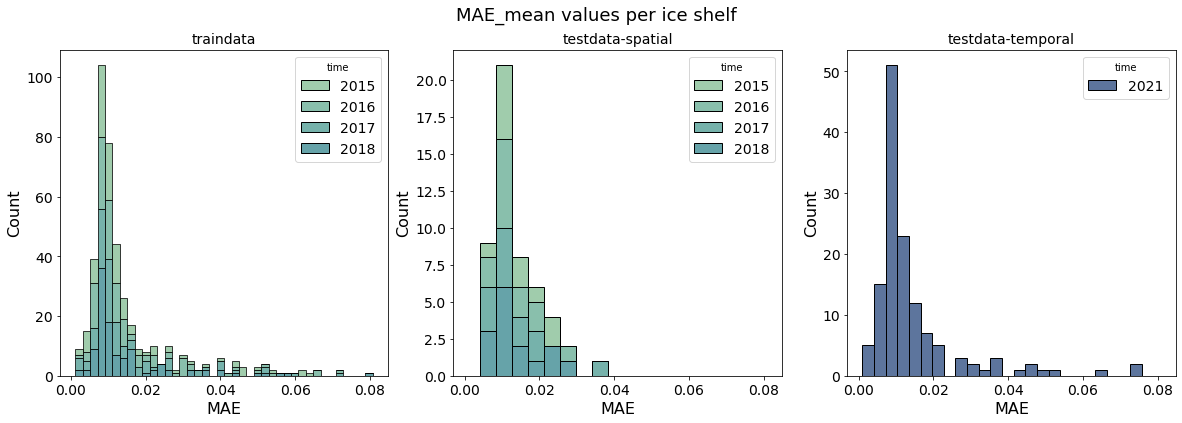

In [ ]:
## STATS for each iceshelf
plot_metric='MAE_mean'

'''
## Traindata
'''

# ## PLOT ONLY TRAINDATA
ssim_iceshelf = stats_train # .values # ssim_df.mean(axis=1)
title_str = 'traindata'

## Plot values
fig,axs=plt.subplots(1,3,figsize=(20,6), sharex=True)
ax=axs[0]
ax = sns.histplot(data=ssim_iceshelf, x=plot_metric, multiple='stack', ax=ax,
                hue='time' ,palette = my_palette2long[1:],legend=True,
                )
ax.set_title(title_str)
ax.set_xlabel('MAE')


'''
## Spatial test
'''

# ## PLOT ONLY TESTDATA-spatial
ssim_iceshelf = stats_test_spatial # ssim_df.mean(axis=1)
title_str = 'testdata-spatial'

## Plot values
ax=axs[1]
ax = sns.histplot(data=ssim_iceshelf, x=plot_metric, multiple='stack',ax=ax,
                hue='time' ,palette = my_palette2long[1:],legend=True,
                )
ax.set_title(title_str)
ax.set_xlabel('MAE')

'''
## Temporal set
'''

## PLOT ONLY TESTDATA-temporal
ssim_iceshelf = stats_test_temporal # ssim_df.mean(axis=1)
title_str = 'testdata-temporal'

## Plot values
ax=axs[2]
ax = sns.histplot(data=ssim_iceshelf, x=plot_metric, multiple='stack',ax=ax,
                hue='time' ,palette = my_palette2long[-1:],legend=True,
                )
ax.set_title(title_str)
ax.set_xlabel('MAE')

fig.suptitle(plot_metric+ ' values per ice shelf ')
# fig.tight_layout()



### Calculate statistics from all pixels per data set (train/test/etc)

In [ ]:

print('METRICS CALCULATED (1) per ice shelf; (2) average of each train/test set')
cols_show = ['mean_SSIM','std_SSIM','MAE','mean_true','std_true']
stats_df_traintest0[cols_show]

METRICS CALCULATED (1) per ice shelf; (2) average of each train/test set


,mean_SSIM,std_SSIM,MAE,mean_true,std_true
traindata,0.798609,0.238154,0.015212,0.025685,0.010362
testdata-spatial,0.717281,0.234125,0.013400,0.020541,0.013663
testdata-temp,0.802046,0.231605,0.014624,0.025214,0.009730
